In [1]:
import numpy as np
import xarray as xr
import sys
import glob
import netCDF4 as nc
import os
import sys
import h5py
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import numpy.matlib
from matplotlib.ticker import MaxNLocator
import copy
import pandas as pd
from scipy.io import savemat
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from functions_ecco_NEW import dayofyear_climo_extended_NEW

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
#import ecco_v4_py as ecco

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

# Inputs

In [2]:
create_var_dict_HARDDRIVE_NEEDED = False

In [3]:
# Region tag for title in plots
title_tag = 'NEP' # NEP SWP TASMAN

# Define years
years = np.arange(1992,2018) # 1992-2017

if title_tag == 'SWP':
    # Define box
    lon_min = 189.5 - 360
    lon_max = lon_min + 30
    lat_min = -45.5
    lat_max = lat_min + 20
    start_time_plot = '2009-01-01'
    end_time_plot = '2013-12-31'
    
elif title_tag == 'TASMAN': # (147°E, 155°E) and (45°S, 37°S)
    # Define box
    lon_min = 147 #- 360
    lon_max = lon_min + 8
    lat_min = -45
    lat_max = lat_min + 8
    start_time_plot = '2015-01-01'
    end_time_plot = '2016-12-31'

elif title_tag == 'NEP':
    # Define box
    lon_min = 209.5 - 360
    lon_max = lon_min + 16
    lat_min = 39.5
    lat_max = lat_min + 11  
    start_time_plot = '2012-01-01'
    end_time_plot = '2016-12-31'




In [4]:
number_of_levels = 5 # that corresponds to 10 levels
levels = np.arange(0,number_of_levels+1,1)
units_tag = 'W'
# Select maximum depth for plots
# plot_ylim = -95 
full_time_period = False

# load_path = f'/Volumes/MyPassportForMac/MAC_15/NASA_project/2023/NEW_heatBudgetECCO_daily/data/outputs/metadata/'
load_path = f'/Users/jacoposala/Downloads/'
plot_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/'

    

## Load data

In [5]:
# Load metadata
ECCO_metadata = ['XC_lon', 'YC_lat', 'Z_depth', 'vol', 'area']

# Create a dictionary to store the variables
ecco_data = {}
for ivar in ECCO_metadata:
    file_path = f"{load_path}/ECCOv4r4_{ivar}_1993_2017.nc"
    # Open the dataset and store it in the dictionary
    ecco_data[ivar] = xr.open_dataset(file_path)
    
# Access the variables using the dictionary
XC_lon = ecco_data['XC_lon']
YC_lat = ecco_data['YC_lat']
Z_depth = ecco_data['Z_depth'].Z_depth.sel(k=slice(None, number_of_levels))
vol = ecco_data['vol']
area = ecco_data['area']


In [6]:
# Cut the region of interest
lat_bounds = np.logical_and(YC_lat.YC_lat > lat_min, YC_lat.YC_lat < lat_max)
lon_bounds = np.logical_and(XC_lon.XC_lon > lon_min, XC_lon.XC_lon < lon_max)
lat_lon_bounds = np.logical_and(lat_bounds, lon_bounds) # if box passes the dateline, we need to add on this line "or np.logical_and(lat_bounds2, lon_bounds2)" 


In [7]:
# varnames_load = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing',
#             'adv_hConv', 'adv_vConv', 'dif_hConv', 'dif_vConv',
#             'G_advection_conv_zon', 'G_advection_conv_mer',
#             'G_diffusion_conv_zon', 'G_diffusion_conv_mer',
#             'DATA']

varnames_load = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing', 'DATA', 'adv_vConv', 'dif_vConv']
varnames = ['G_total', 'G_advection_conv', 'G_diffusion_conv', 'G_forcing', 'DATA', 'adv_vConv', 'dif_vConv']


In [8]:
if create_var_dict_HARDDRIVE_NEEDED:
    for ivar_load, ivar in zip(varnames_load, varnames):
        var_data = []
        path_for_load = '/Volumes/MyPassportForMac/MAC_15/NASA_project/2023/NEW_heatBudgetECCO_daily/data/outputs/single_heat_terms'
        for year in years:
            print(year)
            
            # Load data
            file_path = f'{path_for_load}/{year}/ECCOv4r4_{ivar_load}_cut_{year}.nc'
            dataset = xr.open_dataset(file_path)
            
            print('done: load')
            
            # Filter over box
            if year >= 2004 and (ivar_load == 'G_advection' or ivar_load == 'G_diffusion'): 
                ivar = ivar_load
                dataset_box = dataset[ivar+'_cut'].where(lat_lon_bounds, np.nan)
            else:
                dataset_box = dataset[ivar+'_cut'].where(lat_lon_bounds, np.nan)
            area_box = area['area'].where(lat_lon_bounds, np.nan)
            print('done: box')
            
            # Weighted average
            avg_box = (dataset_box * area_box).sum(["i", "j", "tile"]) / area_box.sum(["i", "j", "tile"])
            avg_box.name = ivar_load
            print('done: avg box')
            var_data.append(avg_box)
            print('done: append')

        # Concatenate the datasets along the time dimension
        var_dataset = xr.concat(var_data, dim='time')
        #var_dataset.name = ivar_load
        
        # Save the dataset as a NetCDF file
        output_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/{title_tag}_avg_box/ECCOv4r4_{ivar_load}_1993_2017_avg_box_{title_tag}.nc'
        #output_path = "avg_box_dsd.nc"
        var_dataset.to_netcdf(output_path)
        print(f'Saved dataset for {ivar_load} as {output_path}')
        
        dataset.close()


In [2]:
import xarray as xr
var_dataset = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/NEP_avg_box/ECCOv4r4_DATA_1993_2017_avg_box_NEP.nc')



In [ ]:
vol

In [3]:
var_dataset_cumsum = copy.deepcopy(var_dataset)

<xarray.Dataset>
Dimensions:  (k: 10, time: 9495)
Coordinates:
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 1992-01-02T12:00:00 ... 2017-12-30T18:00:00
Data variables:
    DATA     (time, k) float32 ...

<xarray.Dataset>
Dimensions:  (j: 90, i: 90, tile: 13, k: 50)
Coordinates: (12/15)
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 ...
    YC       (tile, j, i) float32 ...
    CS       (tile, j, i) float32 ...
    ...       ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    Z        (k) float32 ...
    PHrefC   (k) float32 ...
    drF      (k) float32 ...
    hFacC    (tile, k, j, i) float32 ...
    maskC    (tile, k, j, i) int8 ...
Data variables:
    vol      (tile, k, j, i) float32 ...

In [11]:
Z_depth

<xarray.DataArray 'Z_depth' (k: 6)>
array([ -5., -15., -25., -35., -45., -55.], dtype=float32)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5
Attributes:
    units:      m
    positive:   down
    long_name:  vertical coordinate of cell center

In [ ]:
ciao

In [ ]:
# import xarray as xr
# import numpy as np

# if create_var_dict_HARDDRIVE_NEEDED:
#     # Create a dictionary to store the datasets for each variable
#     datasets = {}

#     for ivar_load, ivar in zip(varnames_load, varnames):
#         var_data = []
#         path_for_load = '/Volumes/MyPassportForMac/MAC_15/NASA_project/2023/NEW_heatBudgetECCO_daily/data/outputs/single_heat_terms'
#         for year in years:
#             print(year)
#             file_path = f'{path_for_load}/{year}/ECCOv4r4_{ivar_load}_cut_{year}.nc'

#             dataset = xr.open_dataset(file_path)
            
#             print('done: load')
#             if year >= 2004 and ivar_load == 'G_advection': 
#                 ivar = ivar_load 
#                 dataset_box = dataset[ivar+'_cut'].where(lat_lon_bounds, np.nan)
#             elif year >= 2004 and ivar_load == 'G_diffusion':
#                 ivar = ivar_load
#                 dataset_box = dataset[ivar+'_cut'].where(lat_lon_bounds, np.nan)
#             else:
#                 dataset_box = dataset[ivar+'_cut'].where(lat_lon_bounds, np.nan)
#             print('done: box')
#             # Weighted average
#             avg_box = (dataset_box * area.area).sum(["i", "j", "tile"]) / area.area.sum(["i", "j", "tile"])
#             avg_box.name = ivar  # Assign a name to the DataArray
#             print('done: avg box')
#             var_data.append(avg_box)
#             print('done: append')

#         # Concatenate the datasets along the time dimension
#         var_dataset = xr.concat(var_data, dim='time')

#         # Create a Dataset from the concatenated DataArray
#         var_dataset = var_dataset.to_dataset(name=ivar)

#         # Rename the variable in the dataset
#         var_dataset = var_dataset.rename({ivar: f'ECCOv4r4_{ivar_load}_1993_2017_avg_box_{title_tag}'})

#         # Store the variable dataset in the dictionary
#         datasets[ivar_load] = var_dataset

#         # Save the dataset as a NetCDF file
#         output_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/{title_tag}_avg_box/ECCOv4r4_{ivar_load}_1993_2017_avg_box_{title_tag}.nc'  # Replace with your desired output path
#         var_dataset.to_netcdf(output_path)
#         print(f'Saved dataset for {ivar_load} as {output_path}')
#         ciao
#         dataset.close()


In [ ]:
# # Store sliced data in the dictionary
# test1 = G_advection_global.G_advection_conv_cut.where(lat_lon_bounds, np.nan)
# avg = (test1* area.area).sum(["i", "j", "tile"]) / area.area.sum(["i", "j", "tile"])
# avg.plot()


In [22]:
# Load weighted average terms
output_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/ECCO_daily_{title_tag}_avg_box/'

# Rename variables in other xarray datasets
G_total_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_total_1992_2017_avg_box_{title_tag}.nc')
G_total_1992_2017_k0_k9_box_wgtd_avg = G_total_1992_2017_k0_k9_box_wgtd_avg.G_total

G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_advection_1992_2017_avg_box_{title_tag}.nc')
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = G_advection_conv_1992_2017_k0_k9_box_wgtd_avg.G_advection

G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_diffusion_1992_2017_avg_box_{title_tag}.nc')
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg.G_diffusion

G_forcing_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_forcing_1992_2017_avg_box_{title_tag}.nc')
G_forcing_1992_2017_k0_k9_box_wgtd_avg = G_forcing_1992_2017_k0_k9_box_wgtd_avg.G_forcing

DATA_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_DATA_1992_2017_avg_box_{title_tag}.nc')
DATA_1992_2017_k0_k9_box_wgtd_avg = DATA_1992_2017_k0_k9_box_wgtd_avg.DATA


In [24]:
varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_forcing_1992_2017_k0_k9_box_wgtd_avg']

# Total convergence of advection and diffusion (horizontal and vertical)
Conv_total_box_wgt_area_avg = G_advection_conv_1992_2017_k0_k9_box_wgtd_avg + G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg

# Sum of terms in RHS of equation
rhs_box_wgt_area_avg = Conv_total_box_wgt_area_avg + G_forcing_1992_2017_k0_k9_box_wgtd_avg

# Residuals calculated within the box
res_2_all_box_wgt_area_avg = rhs_box_wgt_area_avg - G_total_1992_2017_k0_k9_box_wgtd_avg

# varnames_plot.append('res_2_all_box_wgt_area_avg')


## Plot anomalies for DATA


In [25]:
varname_data = ['DATA_1992_2017_k0_k9_box_wgtd_avg']


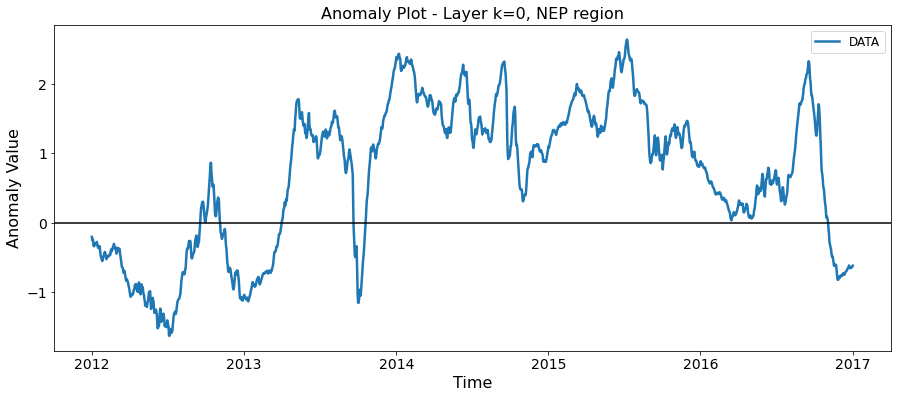

In [26]:
for k_value in range(1):
    # Create a new figure for each layer
    plt.figure(figsize=(15, 6))
    label = 'DATA'
    for varname in varname_data:
        climo = eval(varname).groupby('time.dayofyear').mean('time')
        anom_data = eval(varname).groupby('time.dayofyear') - climo
        cut_data_anom = anom_data.sel(time=slice(start_time_plot, end_time_plot))

        layer_data_anom = cut_data_anom.sel(k=k_value)
        plt.plot(layer_data_anom['time'], layer_data_anom, label=label, linewidth=2.5)

#     plt.ylim(-1E-5, 1E-5)
    plt.title(f'Anomaly Plot - Layer k={k_value}, {title_tag} region', fontsize = 16)
    plt.xlabel('Time', fontsize = 16)
    plt.ylabel('Anomaly Value', fontsize = 16)
    plt.axhline(y=0, color='k')
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 12)
    
#     # Save or show the figure
#     plt.savefig(plot_path + f'DATA_anomalies_lineplot_layer_k{k_value}_{title_tag}_region.png', dpi=1000)
#     plt.show()

## Plot anomalies for each k level - all terms on one plot


In [27]:
# varnames_plot

In [28]:
# for k_value in range(10):
#     # Create a new figure for each layer
#     plt.figure(figsize=(15, 6))
#     labels = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing', 'Residuals']
#     i = 0
#     for varname in varnames_plot:
#         climo = eval(varname).groupby('time.dayofyear').mean('time')
#         anom_data = eval(varname).groupby('time.dayofyear') - climo
#         cut_data_anom = anom_data.sel(time=slice(start_time_plot, end_time_plot))
#         layer_data_anom = cut_data_anom.sel(k=k_value)
#         plt.plot(layer_data_anom['time'], layer_data_anom, label=labels[i])
#         i = i+1

# #     plt.ylim(-1E-5, 1E-5)
#     plt.title(f'Anomaly Plot - Layer k={k_value}, {title_tag} region', fontsize = 16)
#     plt.xlabel('Time', fontsize = 16)
#     plt.ylabel('Anomaly Value', fontsize = 16)
#     plt.legend()
#     plt.xticks(fontsize = 14)
#     plt.yticks(fontsize = 14)
#     plt.legend(fontsize = 12)
    
#     # Save or show the figure
#     plt.savefig(plot_path + f'anomalies_lineplot_layer_k{k_value}_{title_tag}_region.png', dpi=1000)
#     plt.show()
    

## Plot the cumulative sum of the anomalies for each term for each k level


In [29]:
# for k_value in range(10):
#     # Create a new figure for each layer
#     plt.figure(figsize=(15, 6))
#     labels = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing', 'Residuals']
#     i = 0
#     for varname in varnames_plot:
#         climo = eval(varname).groupby('time.month').mean('time')
#         anom_data = eval(varname).groupby('time.month') - climo
#         cut_data_anom = anom_data.sel(time=slice(start_time_plot, end_time_plot))

#         layer_data_anom = cut_data_anom.sel(k=k_value)
#         cumulative_sum = layer_data_anom.cumsum(dim='time')
#         plt.plot(layer_data_anom['time'], cumulative_sum, label=labels[i], linewidth=2.5)
#         i = i+1
        
#     plt.title(f'Cumulative Sum Plot - Layer k={k_value}, {title_tag} region', fontsize = 16)
#     plt.xlabel('Time', fontsize = 16)
#     plt.ylabel('Cumulative Sum', fontsize = 16)
#     plt.legend()
#     plt.xticks(fontsize = 14)
#     plt.yticks(fontsize = 14)
#     plt.legend(fontsize = 12)
    
#     # Save or show the figure
#     plt.savefig(plot_path + f'cumulative_sum_lineplot_layer_k{k_value}_{title_tag}_region.png', dpi=1000)
#     plt.show()


## Calculate cumulative sum between k_min and k_max 


In [30]:
k_min = 0
k_max = 5 # 5 max 9

thickness = np.abs(np.diff(Z_depth))
thickness = np.abs(np.diff(Z_depth))[k_min:k_max]

In [31]:
varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
 'DATA_1992_2017_k0_k9_box_wgtd_avg']

varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_forcing_1992_2017_k0_k9_box_wgtd_avg']

In [34]:
path_2save_mat = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/mat_files'
for ivar in varnames_plot:
    data_all = {}
    data = copy.deepcopy(eval(ivar))
    data_all['data_dayofyear'] = data.time.dt.dayofyear.values
    data_all['data_month'] = data.time.dt.month.values
    data_all['data_year'] = data.time.dt.year.values
    data_all['data_day'] = data.time.dt.day.values
    data_all['data'] = data.values
    savemat(f"{path_2save_mat}/{ivar}_{title_tag}.mat", data_all)


In [35]:
from scipy.interpolate import pchip_interpolate
# var_names = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
#  'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
#  'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
#  'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
#  'DATA_1992_2017_k0_k9_box_wgtd_avg']
var_names = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
            'DATA_1992_2017_k0_k9_box_wgtd_avg']

# var_names = ['DATA_1992_2017_k0_k9_box_wgtd_avg']
# Loop over variables
for var_name in var_names:
    # Load data
    bfr = scipy.io.loadmat(path_2save_mat + '/' + var_name + '_' + title_tag + '.mat')
    data = bfr['data']

    # Initialize array for climatology
    bfr_data_climo = np.empty_like(data) * np.nan
    
    # Loop over each day of the year
    for i in range(len(bfr['data_dayofyear'][0])):

        # Create a mask for the specific day and month
        msk = np.logical_and(bfr['data_month'] == bfr['data_month'][0][i], bfr['data_day'] == bfr['data_day'][0][i])

        # Repeat msk 10 times along the second axis
        msk_repeated = np.broadcast_to(msk.T, data.shape)
        # Apply the repeated mask to each column of the data array
        masked_data = data[msk_repeated].reshape(-1, data.shape[1])

        # Calculate climatological average for the specific day and assign to the mask
        bfr_data_climo[np.where(msk_repeated)] = np.tile(np.nanmean(masked_data, axis=0), (np.sum(msk), 1)).ravel()
    
    # mask for Feb 29 - we average previous day (Feb 28) and following day (Mar 1)
    msk_feb29 = np.logical_and(bfr['data_month'][0] == 2, bfr['data_day'][0] == 29)

    index = np.where(msk_feb29)[0]

    for i_ind in np.arange(0,len(index)):
        bfr_data_climo[index[i_ind],:] = (bfr_data_climo[index[i_ind]-1,:] + bfr_data_climo[index[i_ind]+1,:])/2
#         bfr_data_climo[index[i_ind],:] = bfr_data_climo[index[i_ind]-1,:]
    
        
    # interpolation for Feb 29, Feb 28 and Mar 1 (between Feb 27 and Mar 2)
#     else:
#         for iday, imonth in zip([28,29,1], [2,2,3]):
#             msk_feb28_feb29_mar1 = np.logical_and(bfr['data_month'][0] == imonth, bfr['data_day'][0] == iday)
#             bfr_data_climo[msk_feb28_feb29_mar1,:] = np.nan
    
#         for ilev in np.arange(0, np.shape(bfr_data_climo)[1]):
#             msk = np.isfinite(bfr_data_climo[:, ilev])
#             xint = np.arange(0, np.shape(bfr_data_climo)[0])
#             bfr_data_climo[:,ilev] = scipy.interpolate.pchip_interpolate(xint[msk], \
#                                                bfr_data_climo[msk, ilev], xint)
    
    
    
    # Prepare output dictionary
    bfr_4_output = {
        'data': data,
        'data_dayofyear': bfr['data_dayofyear'],
        'data_month': bfr['data_month'],
        'data_year': bfr['data_year'],
        'data_day': bfr['data_day'],
        'data_climo': bfr_data_climo
    }

    # Use variable name as key in the output dictionary
    globals()[var_name] = bfr_4_output
        

In [ ]:
# msk_test = np.logical_and(bfr['data_month'][0] == 2, bfr['data_day'][0] == 28)
# for k in np.arange(0,5,1):
#     print(np.unique(bfr_data_climo[msk_test,k]))
    

In [ ]:
# msk_test = np.logical_and(bfr['data_month'][0] == 2, bfr['data_day'][0] == 29)
# for k in np.arange(0,5,1):
#     print(np.unique(bfr_data_climo[msk_test,k]))
    

In [ ]:
# msk_test = np.logical_and(bfr['data_month'][0] == 3, bfr['data_day'][0] == 1)
# for k in np.arange(0,5,1):
#     print(np.unique(bfr_data_climo[msk_test,k]))
    

In [ ]:
# for ivar in var_names:
    
#     d2plot = globals()[ivar]
    
#     plt.figure(figsize=(15,6))
#     plt.plot(d2plot['data_climo'])
#     plt.title(ivar)
#     plt.xlim(1,366)  # Set x-axis limits
#     plt.axvline(x=58, linestyle = '--', linewidth=.5)
#     plt.xlim(56,60)
#     plt.ylim(.023, .025)

# #     plt.colorbar()
    

    

In [ ]:
# plt.figure(figsize=(15,6))
# plt.pcolor(np.abs(G_total_1992_2017_k0_k9_box_wgtd_avg['data'] -
#            G_advection_conv_1992_2017_k0_k9_box_wgtd_avg['data'] -
#            G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg['data'] -
#            G_forcing_1992_2017_k0_k9_box_wgtd_avg['data']), vmin = 0, vmax = 2.5E-14)
# plt.colorbar()

In [ ]:
# plt.figure(figsize=(15,6))
# plt.pcolor(np.abs(G_total_1992_2017_k0_k9_box_wgtd_avg['data_climo'] -
#            G_advection_conv_1992_2017_k0_k9_box_wgtd_avg['data_climo'] -
#            G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg['data_climo'] -
#            G_forcing_1992_2017_k0_k9_box_wgtd_avg['data_climo']), vmin = 0, vmax = 2.5E-14)
# plt.colorbar()


In [ ]:
area_global_condition_MHWall = np.load('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/bfr_data_avg_area_tot_NEP_MHWall.np.npy')


In [ ]:
total_area_global = np.load('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/bfr_data_avg_area_tot_NEP_MHWall.npy')



G_total_1992_2017_k0_k9_box_wgtd_avg
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg
G_forcing_1992_2017_k0_k9_box_wgtd_avg


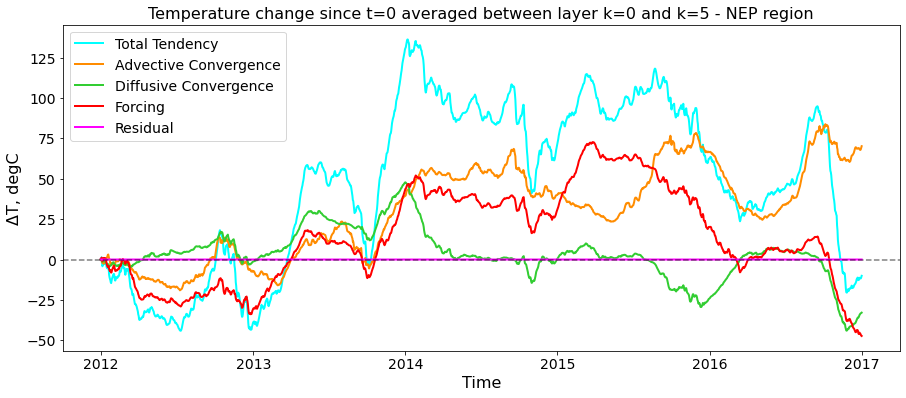

In [37]:
# Make plots between kmin and kmax (OHC)

ind = 0
start_time = datetime.strptime(start_time_plot, '%Y-%m-%d').toordinal()
end_time = datetime.strptime(end_time_plot, '%Y-%m-%d').toordinal()

# cols = plt.cm.jet(np.linspace(0, 1, len(var_names)))
cols = ['aqua', 'darkorange', 'limegreen', 'red', 'black']

labels = []
for ivar in varnames_plot:
    if 'G_total' in ivar:
        labels.append('Total Tendency')
    if 'G_forcing' in ivar:
        labels.append('Forcing')
    if 'G_adv' in ivar:
        labels.append('Advective Convergence')
    if 'G_diff' in ivar:
        labels.append('Diffusive Convergence')
    if 'DATA' in ivar:
        labels.append('ΔT')
        
plt.figure(figsize=(15,6))      
for ivar in range(len(varnames_plot)):
    print(varnames_plot[ivar])
    d2plot = eval(varnames_plot[ivar])

    d2plot_dnum = [datetime(*d).toordinal() for d in zip(d2plot['data_year'][0], d2plot['data_month'][0], d2plot['data_day'][0])]
    d2plot_msk = (np.array(d2plot_dnum) >= start_time) & (np.array(d2plot_dnum) <= end_time)
    
    d2plot_val = d2plot['data'] - d2plot['data_climo']
    d2plot_val_sel = d2plot_val[d2plot_msk]
    
    
    d2plot_val_sel = ((d2plot_val_sel[:, k_min+1:k_max+1] + d2plot_val_sel[:, k_min:k_max])
                        * thickness).sum(axis=1) / 2
    
    
    ordinal_dates = np.array(d2plot_dnum)[d2plot_msk]
    
    datetime_time = [datetime.fromordinal(date) for date in ordinal_dates]

    
    if 'DATA' in var_names[ivar]:
        plt.plot(datetime_time, d2plot_val_sel - d2plot_val_sel[0], color=cols[ivar], label='ΔT', linewidth=1.5, linestyle='--')
    else:
        plt.plot(datetime_time, np.cumsum(d2plot_val_sel) * 24 * 3600, color=cols[ivar], label=labels[ivar], linewidth=2, linestyle='-')

# Add residuals to plot
plt.plot(datetime_time, res_2_all_box_wgt_area_avg.sel(time=slice(start_time_plot, end_time_plot))[:,ind], color='fuchsia', label='Residual', linewidth=2, linestyle='-')

plt.title(f'Temperature change since t=0 averaged between layer k={k_min} and k={k_max} - {title_tag} region', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('ΔT, degC', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.ylim(-2,+1)
# plt.ylim(-.3,.3)
# plt.ylim(-1,1)
plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1.5)
plt.legend(fontsize=14)
# plt.savefig(plot_path + f'temperature_change_lineplot_layer_k{k_min}_k{k_max}_{title_tag}_region.png', dpi=1000)
plt.show()


In [ ]:
ciao

In [ ]:
# Make plots for each layer 

k_lev = [0,1,2,3,4,5]

# start_time_plot = '1992-01-02'
# end_time_plot = '1992-12-31'

start_time = datetime.strptime(start_time_plot, '%Y-%m-%d').toordinal()
end_time = datetime.strptime(end_time_plot, '%Y-%m-%d').toordinal()

# cols = plt.cm.jet(np.linspace(0, 1, len(var_names)))
cols = ['aqua', 'darkorange', 'limegreen', 'red', 'black']

labels = []
for ivar in varnames_plot:
    if 'G_total' in ivar:
        labels.append('Total Tendency')
    if 'G_forcing' in ivar:
        labels.append('Forcing')
    if 'G_adv' in ivar:
        labels.append('Advective Convergence')
    if 'G_diff' in ivar:
        labels.append('Diffusive Convergence')
    if 'DATA' in ivar:
        labels.append('ΔT')
        
for i_k in k_lev:
    plt.figure(figsize=(15,6))      
    for ivar in range(len(varnames_plot)):
        print(varnames_plot[ivar])
        d2plot = eval(varnames_plot[ivar])

        d2plot_dnum = [datetime(*d).toordinal() for d in zip(d2plot['data_year'][0], d2plot['data_month'][0], d2plot['data_day'][0])]
        d2plot_msk = (np.array(d2plot_dnum) >= start_time) & (np.array(d2plot_dnum) <= end_time)

        d2plot_val = d2plot['data'][:,i_k] - d2plot['data_climo'][:,i_k]
        d2plot_val_sel = d2plot_val[d2plot_msk]


        ordinal_dates = np.array(d2plot_dnum)[d2plot_msk]

        datetime_time = [datetime.fromordinal(date) for date in ordinal_dates]


        if 'DATA' in var_names[ivar]:
            plt.plot(datetime_time, d2plot_val_sel - d2plot_val_sel[0], color=cols[ivar], label='ΔT', linewidth=1.5, linestyle='--')
        else:
            plt.plot(datetime_time, np.cumsum(d2plot_val_sel) * 24 * 3600, color=cols[ivar], label=labels[ivar], linewidth=2, linestyle='-')

    # Add residuals to plot
    plt.plot(datetime_time, res_2_all_box_wgt_area_avg.sel(time=slice(start_time_plot, end_time_plot))[:,ind], color='fuchsia', label='Residual', linewidth=2, linestyle='-')

    plt.title(f'Temperature change since t=0 averaged for layer k={i_k} - {title_tag} region', fontsize = 16)
    plt.xlabel('Time', fontsize = 16)
    plt.ylabel('ΔT, degC', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1.5)
    plt.legend(fontsize=14)
#     plt.xlim(datetime(2012, 2, 1), datetime(2012, 4, 30))  # Set x-axis limits

#     plt.savefig(plot_path + f'temperature_change_lineplot_layer_k{i_k}_{title_tag}_region.png', dpi=1000)
    
    plt.show()
    plt.close()


In [ ]:
d2plot_val_sel.shape

In [ ]:
ciao

In [ ]:
DATA_1992_2017_k0_k9_box_wgtd_avg

In [ ]:
plt.plot(DATA_1992_2017_k0_k9_box_wgtd_avg.time[8500:9000], DATA_1992_2017_k0_k9_box_wgtd_avg[8500:9000,0])


In [ ]:
# def dayofyear_climo_extended_NEW(varname_input, var_input):
#     data_input = copy.deepcopy(var_input).to_dataset()
#     data_input = data_input - data_input.mean(dim='time')
#     print(data_input)
    
    
#     bfr_climo_extended_year_array = data_input.time.dt.year.values
    
#     bfr_climo_extended_dayofyear_array = data_input.time.dt.dayofyear.values
    
#     data_input_values = data_input[varname_input].values
    
# #     print(type(bfr_climo_extended_values))
# #     print(np.shape(bfr_climo_extended_values))
# #     print(bfr_climo_extended_values)
#     output_climo_extended_values = copy.deepcopy(data_input_values)
    
#     for i in np.arange(0, np.shape(output_climo_extended_values)[0]):
#         mask_climo = bfr_climo_extended_dayofyear_array == bfr_climo_extended_dayofyear_array[i]
#         output_climo_extended_values[mask_climo,:] = np.mean(data_input_values[mask_climo,:])
    
# #     plt.plot(output_climo_extended_values[0:365,0])
# #     plt.plot(data_input_values[0:365,0])
    
#     output_climo_extended = copy.deepcopy(data_input)
#     output_climo_extended[varname_input] = (('time', 'k'), output_climo_extended_values)
#     output_climo_extended = output_climo_extended + data_input.mean(dim='time')
    
#     return(output_climo_extended[varname_input])


In [ ]:
# Define variables to plot

thickness = np.abs(np.diff(Z_depth))
thickness = np.abs(np.diff(Z_depth))[k_min:k_max]

vars2plot = []
vars2plot_diff = []

for varname in varnames_plot:
    print(varname)
    climo = eval(varname).groupby('time.dayofyear').mean('time') # shape (366, 10): days & levels
    climo_NEW = dayofyear_climo_extended_NEW(varname_input=varname, var_input=eval(varname))
    anom_data = eval(varname) - climo_NEW #dayofyear_climo_extended(varname_input = varname, var_input=eval(varname), climo=climo)
    anom_data = climo_NEW #dayofyear_climo_extended(varname_input = varname, var_input=eval(varname), climo=climo)
#     anom_data = eval(varname).groupby('time.dayofyear') - climo
    cut_data_anom = anom_data.sel(time=slice(start_time_plot, end_time_plot))

    # TRAPEZOIDAL RULE
    variable_integral = ((cut_data_anom[:, k_min+1:k_max+1].values + cut_data_anom[:, k_min:k_max].values)
                        * thickness).sum(axis=1) / 2

    
    if 'DATA' in varname:
        var2save = (variable_integral - variable_integral[0])/np.abs(np.sum(thickness))
    else:
        cumulative_sum = np.cumsum(variable_integral)
        var2save = cumulative_sum*24*60*60/np.abs(np.sum(thickness))
        
    vars2plot.append(var2save)
    
#     vars2plot_diff.append(var2save-vars2plot[0])


In [ ]:
# # Plotting cumulative sums for each term on one single plot
# plt.figure(figsize=(15, 6))

# labels = []
# for ivar in varnames_plot:
#     if 'G_total' in ivar:
#         labels.append('Total Tendency')
#     if 'G_forcing' in ivar:
#         labels.append('Forcing')
#     if 'G_adv' in ivar:
#         labels.append('Advective Convergence')
#     if 'G_diff' in ivar:
#         labels.append('Diffusive Convergence')
#     if 'res' in ivar:
#         labels.append('Residual')
#     if 'DATA' in ivar:
#         labels.append('ΔT')

# colors = ['red', 'green', 'blue', 'magenta', 'black', 'grey']
# lstlye = ['-', '-', '-', '-', '-', '-']
# i = 0
# for varname, ivars2plot in zip(varnames_plot, vars2plot):
#     plt.plot(cut_data_anom.time, ivars2plot, label=labels[i], linewidth=1.5, color=colors[i], linestyle=lstlye[i])
#     i = i+1
# plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5)
# # if varname
# plt.title(f'Temperature change since t=0 averaged between layer k={k_min} and k={k_max} - {title_tag} region', fontsize = 16)
# plt.xlabel('Time', fontsize = 16)
# plt.ylabel('ΔT, degC', fontsize = 16)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.legend(fontsize = 12)
# # plt.ylim(-.0001, .0001)
# # plt.savefig(plot_path + f'cumulative_sum_integral_lineplot_layer_k{k_min}_k{k_max}_{title_tag}_region.png', dpi=1000)
# plt.show()


In [ ]:
# # Plotting cumulative sums for each term on one single plot
# plt.figure(figsize=(15, 6))

# labels = []
# for ivar in varnames_plot:
#     if 'G_total' in ivar:
#         labels.append('Total Tendency')
#     if 'G_forcing' in ivar:
#         labels.append('Forcing')
#     if 'G_adv' in ivar:
#         labels.append('Advective Convergence')
#     if 'G_diff' in ivar:
#         labels.append('Diffusive Convergence')
#     if 'res' in ivar:
#         labels.append('Residual')
#     if 'DATA' in ivar:
#         labels.append('ΔT')

# colors = ['red', 'green', 'blue', 'magenta', 'black', 'grey']
# lstlye = ['-', '-', '-', '-', '-', '-']
# i = 0
# for varname, ivars2plot in zip(varnames_plot, vars2plot):
#     plt.plot(cut_data_anom.time, ivars2plot, label=labels[i], linewidth=1.5, color=colors[i], linestyle=lstlye[i])
#     i = i+1
# plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5)
# # if varname
# plt.title(f'Temperature change since t=0 averaged between layer k={k_min} and k={k_max} - {title_tag} region', fontsize = 16)
# plt.xlabel('Time', fontsize = 16)
# plt.ylabel('ΔT, degC', fontsize = 16)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.legend(fontsize = 12)
# # plt.ylim(-.0001, .0001)
# # plt.savefig(plot_path + f'cumulative_sum_integral_lineplot_layer_k{k_min}_k{k_max}_{title_tag}_region.png', dpi=1000)
# plt.show()


In [ ]:
# def dayofyear_climo_extended(varname_input, var_input, climo):
#     bfr_climo_extended = copy.deepcopy(var_input).to_dataset()
#     bfr_climo = climo.values

# #     bfr_climo_extended_year = [pd.DatetimeIndex([x]).year for x in bfr_climo_extended.coords['time'].time.values]
# #     bfr_climo_extended_year_array = np.vstack([x.values.flatten() for x in bfr_climo_extended_year]).flatten()
# #     bfr_climo_extended_dayofyear = [pd.DatetimeIndex([x]).dayofyear for x in bfr_climo_extended.coords['time'].time.values]
# #     bfr_climo_extended_dayofyear_array = np.vstack([x.values.flatten() for x in bfr_climo_extended_dayofyear]).flatten()
#     bfr_climo_extended_year_array = bfr_climo_extended.time.dt.year.values
#     bfr_climo_extended_dayofyear_array = bfr_climo_extended.time.dt.dayofyear.values
#     print(type(bfr_climo_extended_dayofyear_array))
#     print(np.shape(bfr_climo_extended_dayofyear_array))
#     print(bfr_climo_extended_dayofyear_array)
#     ciao
#     n = len(np.unique(bfr_climo_extended_year))

#     bfr_climo_extended_var = bfr_climo_extended[varname_input].values*np.nan

#     for iii, iday in enumerate(np.arange(1,np.shape(bfr_climo)[0]+1)):
#         for ilev in np.arange(0,np.shape(bfr_climo_extended_var)[1]):
# #             mask_idx = np.where(bfr_climo_extended_dayofyear_array == iday)
#             mask_idx = []
#             mask_idx_year = []
#             for i, j in enumerate(bfr_climo_extended_dayofyear_array):
#                 if j == iday:
#                     mask_idx.append(i)
#                     mask_idx_year.append(bfr_climo_extended_year_array[i])

            
#             for iidx, idx in enumerate(mask_idx):

#                 if pd.Timestamp(bfr_climo_extended_year_array[iidx],12,31).dayofyear == 366: # leap year

#                     bfr_climo_extended_var[idx, ilev] = bfr_climo[iii, ilev]
                    
#                 else: # not-leap year
                    
#                     if idx <= 59:
#                         bfr_climo_extended_var[idx, ilev] = bfr_climo[iii, ilev]
#                     else:
#                         bfr_climo_extended_var[idx, ilev] = bfr_climo[iii+1, ilev]
                        

# #             bfr_climo_extended_var[mask_idx, ilev] = bfr_climo[iii, ilev]
            
#     bfr_climo_extended[varname_input] = (("time","k"), bfr_climo_extended_var)
#     return(bfr_climo_extended[varname_input])


In [ ]:
# def dayofyear_climo_extended_NEW(varname_input, var_input):
#     data_input = copy.deepcopy(var_input).to_dataset()

#     bfr_climo_extended_year_array = data_input.time.dt.year.values
#     bfr_climo_extended_dayofyear_array = data_input.time.dt.dayofyear.values
#     data_input_values = data_input[varname_input].values
    
# #     print(type(bfr_climo_extended_values))
# #     print(np.shape(bfr_climo_extended_values))
# #     print(bfr_climo_extended_values)
#     output_climo_extended_values = copy.deepcopy(data_input_values)
    
#     for i in np.arange(0, np.shape(output_climo_extended_values)[0]):
#         mask_climo = bfr_climo_extended_dayofyear_array == bfr_climo_extended_dayofyear_array[i]
#         output_climo_extended_values[mask_climo,:] = np.mean(data_input_values[mask_climo,:])
    
# #     plt.plot(output_climo_extended_values[0:365,0])
# #     plt.plot(data_input_values[0:365,0])
    
#     output_climo_extended = copy.deepcopy(data_input)
#     output_climo_extended[varname_input] = (('time', 'k'), output_climo_extended_values)
    
#     return(output_climo_extended[varname_input])
    


In [ ]:
ciao

In [ ]:
# DATA (degC) -> DATA_anom -> weighted avg -> DATA_wgt_avg (degC) -> integral k0-k5 -> 

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Define the coordinates for the three regions and their labels
regions = [
    {"lon_min": 189.5 - 360, "lon_max": 189.5 - 360 + 30, "lat_min": -45.5, "lat_max": -45.5 + 20, "label": "1"},
    {"lon_min": 147, "lon_max": 147 + 8, "lat_min": -45, "lat_max": -45 + 8, "label": "2"},
    {"lon_min": 209.5 - 360, "lon_max": 209.5 - 360 + 16, "lat_min": 39.5, "lat_max": 39.5 + 11, "label": "3"}
]

# Create a map
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

# Add continents and coastlines
ax.coastlines(resolution='10m', linewidth=0.5)
ax.stock_img()

# Plot the boxes
for region in regions:
    ax.plot([region["lon_min"], region["lon_max"], region["lon_max"], region["lon_min"], region["lon_min"]],
            [region["lat_min"], region["lat_min"], region["lat_max"], region["lat_max"], region["lat_min"]],
            color='red', transform=ccrs.PlateCarree())
    
    # Add labels to the regions
    ax.text((region["lon_min"] + region["lon_max"]) / 2, (region["lat_min"] + region["lat_max"]) / 2, region["label"],
            horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize = 15)

# Set extent and gridlines centered at 180 longitude (Pacific Ocean in the middle)
ax.set_extent([-80, 80, -90, 90], crs=ccrs.PlateCarree(central_longitude=180))

# Add title and show plot
# plt.title('Three Boxes with Red Lines and Background Continents and Sea')
plt.show()


## Plot a map of the SST anomaly (Dec 2015-Feb 2016) to reproduce Oliver et al

In [ ]:
import ecco_v4_py as ecco


In [ ]:
# DATA_2plot_map_k0 = DATA_tile8_1992_2017_k0_k9[:,0,:,:]
# climo = DATA_2plot_map_k0.sel(time=slice('1992-01-01', '2005-12-31')).groupby('time.dayofyear').mean('time')
# anom_data = DATA_2plot_map_k0.groupby('time.dayofyear') - climo
# cut_data_anom = anom_data.sel(time=slice('2015-12-01', '2016-02-29'))
# anom_data.to_netcdf('SST_anom_TASMAN.nc4')


In [ ]:
SST_anom_TASMAN = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/SST_anom_TASMAN.nc4')


In [ ]:
SST_anom_TASMAN_cut = SST_anom_TASMAN.sel(time=slice('2015-12-01', '2016-02-29'))

In [ ]:
mean_SST_anom_TASMAN_cut = SST_anom_TASMAN_cut.DATA_tile8.mean('time')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import TwoSlopeNorm

# Assuming your DataArray is named 'your_data_array'
data_array = mean_SST_anom_TASMAN_cut
XC_lon['XC_lon'] = xr.where(XC_lon['XC_lon'] < 0, XC_lon['XC_lon'] + 360, XC_lon['XC_lon'])

# Set up the plot
fig = plt.figure(figsize=(10,8), dpi= 90)
ax = plt.axes(projection=ccrs.PlateCarree())

# Set up levels and a centered norm
levels = np.linspace(-5, 5, 21)
cmap = 'bwr'
norm = BoundaryNorm(levels, ncolors=256)

# Set up levels and a centered norm
levels = [-3.5, -2.5, -2, -1.5, -1, 1, 1.5, 2, 2.5, 3.5]
cmap = 'bwr'
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)


# Plot using contourf
contour_plot = plt.contourf(XC_lon.XC_lon, YC_lat.YC_lat, data_array, 
                            cmap=cmap, levels=levels, norm=norm, 
                            transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND)

plt.xlim([143,180])
plt.ylim([-55,-5])

# Add colorbar with white in the center
cbar = plt.colorbar(contour_plot, extend='both')
cbar.set_label('Temperature Anomaly (deg C)', fontsize = 14)

# Show the plot
plt.show()



## Plot depth vs time

### Define time range to plot

In [ ]:
if full_time_period: 
    #Define time for plotting - FULL TIME SERIES
    plot_xlim_min = datetime.strptime("Jan 1 1993 01:00AM", '%b %d %Y %I:%M%p')
    plot_xlim_year_month_min = '1993_01'
    plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
    plot_xlim_year_month_max = '2016_12'    
else: 
    if title_tag == 'NEP':
        # Define time for plotting - BLOB REGION
        plot_xlim_min = datetime.strptime("Jan 1 2012 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2012_01'
        plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2016_12'
    elif title_tag == 'SWP':
        # Define time for plotting - SW PACIFIC REGION
        plot_xlim_min = datetime.strptime("Jan 1 2009 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2009_01'
        plot_xlim_max = datetime.strptime("Dec 31 2013 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2013_12'    
#         plot_xlim_min = datetime.strptime("Jan 1 2005 01:00AM", '%b %d %Y %I:%M%p')
#         plot_xlim_year_month_min = '2005_01'
#         plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
#         plot_xlim_year_month_max = '2016_12' 
    elif title_tag == 'TASMAN':
        # Define time for plotting - SW PACIFIC REGION
        plot_xlim_min = datetime.strptime("Sep 1 2015 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2015_09'
        plot_xlim_max = datetime.strptime("Aug 31 2016 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2016_08'  

In [ ]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super(MidpointNormalize, self).__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
def ecco_plot_time_vs_depth_JS_auto_limits(ivar, ivar_tag, ivar_box_tag):
    # Remove seasonal cycle
    if ivar in ['DATA']:
        bfr = eval(ivar).transpose()
    else:
        bfr = eval(ivar + ivar_box_tag).transpose()
    climo=bfr.groupby('time.month').mean('time')
    bfr_anom=bfr.groupby('time.month')-climo
    bfr_2plot = eval('bfr'+ivar_tag)
#     if flag_density:
#         bfr_rho_cont = eval('RHOAnoma' + ivar_box_tag)# + ivar_tag) # density should be calculated just using the total
    fig = plt.figure(figsize=(15,6))
    
    clim_calc = max(np.abs(np.quantile(bfr_2plot,0)),np.abs(np.quantile(bfr_2plot,1)))
    mylevs = np.linspace(-clim_calc, + clim_calc, 61)
    norm = MidpointNormalize(midpoint=0)
    
    
    clim = 3e-6
    mylevs = np.linspace(-clim, clim, 31)
    
    
#     max_abs_var = max(max(bfr_2plot))
#     mylevs = np.linspace(-max_abs_var, max_abs_var, 31)
    # Plot variables
#     plt.contourf(bfr_anom.time, Z_depth, bfr_2plot, cmap=plt.cm.bwr)#, levels=mylevs, vmin=min(mylevs), vmax=max(mylevs), extend = 'both')
    plt.contourf(bfr_anom.time, Z_depth, bfr_2plot.values, cmap=plt.cm.bwr, levels=mylevs, norm=norm, vmin=min(mylevs), vmax=max(mylevs), extend = 'both')
#     print(Z_depth)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)
    # Plot rho countours with or without seasonal anomalies
#     if flag_density:
#         plt.contour(bfr_rho_cont.time, Z_depth, bfr_rho_cont.transpose()+1029, colors='k', levels=np.arange(1020,1028,.5), linewidths = 0.5)
    if ivar in ['ConvH_total_horiz']:
        plt.title(ivar.split('_tile8')[0] + ivar_tag +' (degC m3/s)' + ', ' + title_tag, fontsize = 14)
    else:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (' + units_tag + '), ' + title_tag, fontsize = 14)
    plt.ylim(plot_ylim,0) 
    plt.xlabel('Year', fontsize = 12)
    plt.xlim(plot_xlim_min, plot_xlim_max)
    plt.ylabel('Depth, m', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    fig.tight_layout() 
#     if ivar_tag =='':
#         fig.savefig('./depth_vs_time_plots' + '/total/' + 'depth_vs_time_' \
#                     + ivar + '_' + title_tag + '_' + plot_xlim_year_month_min \
#                     + '_' + plot_xlim_year_month_max + ivar_tag + '.jpg', dpi = 900, bbox_inches='tight')
#     else:
#         fig.savefig('./depth_vs_time_plots' + '/anom/' + 'depth_vs_time_' \
#                     + ivar + '_' + title_tag + '_' + plot_xlim_year_month_min \
#                     + '_' + plot_xlim_year_month_max + ivar_tag + '.jpg', dpi = 900, bbox_inches='tight') 

### Actual plots


In [ ]:
varnames_plot = ['G_total_tile8_1992_2017_k0_k9_box', 'G_advection_conv_tile8_1992_2017_k0_k9_box', \
                 'G_diffusion_conv_tile8_1992_2017_k0_k9_box', 'G_forcing_tile8_1992_2017_k0_k9_box']


In [ ]:
ivar_box_tag = '_wgtd_avg_' + title_tag

for ivar_tag in ['', '_anom']:
    for ivar in varnames_plot:
        # Avoid plots of non-relevant terms
        if (ivar not in ['time', 'XC_lon','YC_lat','Z_depth','vol','area']):
            ecco_plot_time_vs_depth_JS_auto_limits(ivar, ivar_tag, ivar_box_tag)
            

In [ ]:
def ecco_plot_time_vs_depth_JS_cumulative_sum(ivar, ivar_tag, ivar_box_tag):
    # Remove seasonal cycle
    if ivar in ['DATA']:
        bfr = eval(ivar).transpose()
    else:
        bfr = eval(ivar + ivar_box_tag).transpose()
    climo = bfr.groupby('time.month').mean('time')
    bfr_anom = bfr.groupby('time.month') - climo

    # Calculate cumulative sum in time
    bfr_anom_cumul = bfr_anom.cumsum(axis=0)  # Sum along the time axis

    bfr_2plot = eval('bfr' + ivar_tag)

    # Plot variables
    fig = plt.figure(figsize=(15, 6))

    # Adjust clim_calc and mylevs based on cumulative sum behavior
#     clim_calc = max(abs(np.min(bfr_anom_cumul)), abs(np.max(bfr_anom_cumul)))
#     mylevs = np.linspace(-clim_calc, +clim_calc, 61)
    clim_calc = max(np.abs(np.quantile(bfr_2plot,0)),np.abs(np.quantile(bfr_2plot,1)))
    mylevs = np.linspace(-clim_calc, + clim_calc, 61)
    norm = MidpointNormalize(midpoint=0)
    
    
    clim = 5e-6
    mylevs = np.linspace(-clim, clim, 31)
    
    norm = MidpointNormalize(midpoint=0)

    plt.contourf(bfr_anom_cumul.time, Z_depth, bfr_anom_cumul.values,
                cmap=plt.cm.bwr, levels=mylevs, norm=norm,
                vmin=min(mylevs), vmax=max(mylevs), extend='both')

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)

    # Adjust title based on cumulative sum
    if ivar in ['ConvH_total_horiz']:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (cumulative degC m3/s)' + ', ' + title_tag, fontsize=14)
    else:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (cumulative ' + units_tag + '), ' + title_tag, fontsize=14)

    plt.ylim(plot_ylim, 0)
    plt.xlabel('Year', fontsize=12)
    plt.xlim(plot_xlim_min, plot_xlim_max)
    plt.ylabel('Depth, m', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    fig.tight_layout()


In [ ]:
ivar_box_tag = '_wgtd_avg_' + title_tag

for ivar_tag in ['', '_anom']:
    for ivar in varnames_plot:
        # Avoid plots of non-relevant terms
        if (ivar not in ['time', 'XC_lon','YC_lat','Z_depth','vol','area']):
            ecco_plot_time_vs_depth_JS_cumulative_sum(ivar, ivar_tag, ivar_box_tag)